# Semantic Segmentation: UNET for Self-Driving Cars

Semantic image segmentation is the task of classifying each pixel in an image from a predefined set of classes. In the following example, different entities are classified.

In particular, our goal is to take a 2D image of size W x H x 3 and generate a W x H matrix containing the predicted class ID’s corresponding to all the pixels.

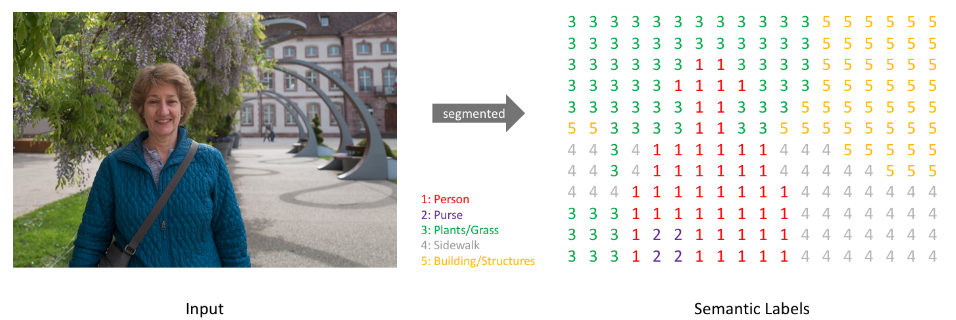

### Import Dependencies

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm 
import tensorflow
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.utils import normalize
# from sklearn.utils import class_weight

In [2]:
tf.__version__

'2.11.0'

In [3]:
np.random.seed(2024)
SIZE = 256      # (heigth x width)

In [4]:
classes = pd.read_csv("CamVid\\class_dict.csv", index_col =0)
classes.T

name,Animal,Archway,Bicyclist,Bridge,Building,Car,CartLuggagePram,Child,Column_Pole,Fence,...,SUVPickupTruck,TrafficCone,TrafficLight,Train,Tree,Truck_Bus,Tunnel,VegetationMisc,Void,Wall
r,64,192,0,0,128,64,64,192,192,64,...,64,0,0,192,128,192,64,192,0,64
g,128,0,128,128,0,0,0,128,192,64,...,128,0,64,64,128,128,0,192,0,192
b,64,128,192,64,0,128,192,64,128,128,...,192,64,64,128,0,192,64,0,0,0


In [5]:
cls2rgb = {clas:list(classes.loc[clas, :]) for clas in classes.index}

In [6]:
cls2rgb.keys(), cls2rgb.values()

(dict_keys(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone', 'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall']),
 dict_values([[64, 128, 64], [192, 0, 128], [0, 128, 192], [0, 128, 64], [128, 0, 0], [64, 0, 128], [64, 0, 192], [192, 128, 64], [192, 192, 128], [64, 64, 128], [128, 0, 192], [192, 0, 64], [128, 128, 64], [192, 0, 192], [128, 64, 64], [64, 192, 128], [64, 64, 0], [128, 64, 128], [128, 128, 192], [0, 0, 192], [192, 128, 128], [128, 128, 128], [64, 128, 192], [0, 0, 64], [0, 64, 64], [192, 64, 128], [128, 128, 0], [192, 128, 192], [64, 0, 64], [192, 192, 0], [0, 0, 0], [64, 192, 0]]))

In [7]:
idx2rgb={idx:np.array(rgb) for idx, (cl, rgb) in enumerate(cls2rgb.items())}

In [8]:
idx2rgb.keys(), idx2rgb.values()

(dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 dict_values([array([ 64, 128,  64]), array([192,   0, 128]), array([  0, 128, 192]), array([  0, 128,  64]), array([128,   0,   0]), array([ 64,   0, 128]), array([ 64,   0, 192]), array([192, 128,  64]), array([192, 192, 128]), array([ 64,  64, 128]), array([128,   0, 192]), array([192,   0,  64]), array([128, 128,  64]), array([192,   0, 192]), array([128,  64,  64]), array([ 64, 192, 128]), array([64, 64,  0]), array([128,  64, 128]), array([128, 128, 192]), array([  0,   0, 192]), array([192, 128, 128]), array([128, 128, 128]), array([ 64, 128, 192]), array([ 0,  0, 64]), array([ 0, 64, 64]), array([192,  64, 128]), array([128, 128,   0]), array([192, 128, 192]), array([64,  0, 64]), array([192, 192,   0]), array([0, 0, 0]), array([ 64, 192,   0])]))

### Functions

In [9]:
def load_images(paths, size=SIZE):
    img_list = []

    for image_path in paths:
        img = cv2.imread(image_path)                                        # 0 to convert to grayscale (should ontain an array (n, h, w, 1) <=> (n, h, w))
        img = cv2.cvtColor((img).astype(np.uint8), cv2.COLOR_BGR2RGB)       # If you want to get the same order as in the color mapping of CAMVID, use the cv converted
        img = cv2.resize(img, (SIZE, SIZE))                                 # with default interpolation = bilinear
        img_list.append(img)
    
    return np.array(img_list)



def show_pairs(images, masks, cmap=None):
    if images.shape[0] != masks.shape[0]:
        raise ValueError("Number of images must be equal to the number of masks.")
    
    if len(images.shape) != 4:      # means that it's a single pair of images to be plotted
        plt.subplot(1,2,1)
        plt.imshow(images)
        plt.subplot(1,2,2)
        plt.imshow(masks)
    
    else:
        n = images.shape[0]
        fig, axs = plt.subplots(nrows=n, ncols=2, figsize=(8,3*n))
        for i in range(n):
            axs[i, 0].imshow(images[i])
            axs[i, 1].imshow(masks[i], cmap=cmap)
        plt.tight_layout()



def adjust_mask(mask, flat=False):

    semantic_map = []
    for colour in list(cls2rgb.values()):        
        equality = np.equal(mask, colour)               # 256x256x3 with True or False
        class_map = np.all(equality, axis = -1)         # 256x256 If all True, then True, else False
        semantic_map.append(class_map)                  # List of 256x256 arrays, map of True for a given found color at the pixel, and False otherwise.
    semantic_map = np.stack(semantic_map, axis=-1)      # 256x256x32 True only at the found color, and all False otherwise.
    if flat:
      semantic_map = np.reshape(semantic_map, (-1,256*256))

    return np.float32(semantic_map)                     # convert to numbers


# Map the idx back to rgb
def map_class_to_rgb(p):
  return idx2rgb[p[0]]

# rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(new_mask, axis=-1), -1))

With these last 2 functions we "encode" the "revert" the mask's RGB channel into a an encoded mask. In simple terms:
- new_mask = adjust_mask(mask) -> this new_mask will have shape (256, 256, 32) where 32 is the number of channels of the image each representing one of the classes
- rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(new_mask, axis=-1), -1)) -> rgb_mask will be the reverted mask turning into shape (256, 256, 3). rgb_mask is basically the same exact thing as the mask given in input to the adjust_mask function

### Data Loading

In [10]:
# https://www.kaggle.com/code/vbookshelf/cnn-how-to-use-160-000-images-without-crashing
# datagen = ImageDataGenerator(rescale=1.0/255)

# train_gen = datagen.flow_from_directory(train_path,
#                                         target_size=(IMAGE_SIZE,IMAGE_SIZE),
#                                         batch_size=train_batch_size,
#                                         class_mode='categorical')

# val_gen = datagen.flow_from_directory(valid_path,
#                                         target_size=(IMAGE_SIZE,IMAGE_SIZE),
#                                         batch_size=val_batch_size,
#                                         class_mode='categorical')

# # Note: shuffle=False causes the test dataset to not be shuffled
# test_gen = datagen.flow_from_directory(valid_path,
#                                         target_size=(IMAGE_SIZE,IMAGE_SIZE),
#                                         batch_size=1,
#                                         class_mode='categorical',
#                                         shuffle=False)

In [11]:
root_path = 'CamVid'

train_image_paths = sorted(glob(os.path.join(root_path, 'train/*')))
train_mask_paths = sorted(glob(os.path.join(root_path, 'train_labels/*')))

val_image_paths = sorted(glob(os.path.join(root_path, 'val/*')))
val_mask_paths = sorted(glob(os.path.join(root_path, 'val_labels/*')))

test_image_paths = sorted(glob(os.path.join(root_path, 'test/*')))
test_mask_paths = sorted(glob(os.path.join(root_path, 'test_labels/*')))

In [12]:
# load data
train_images = load_images(train_image_paths)
train_masks = load_images(train_mask_paths)

In [13]:
val_images = load_images(val_image_paths)
val_masks = load_images(val_mask_paths)

In [14]:
test_images = load_images(test_image_paths)
test_masks = load_images(test_mask_paths)

png > jpg. the lose less info.

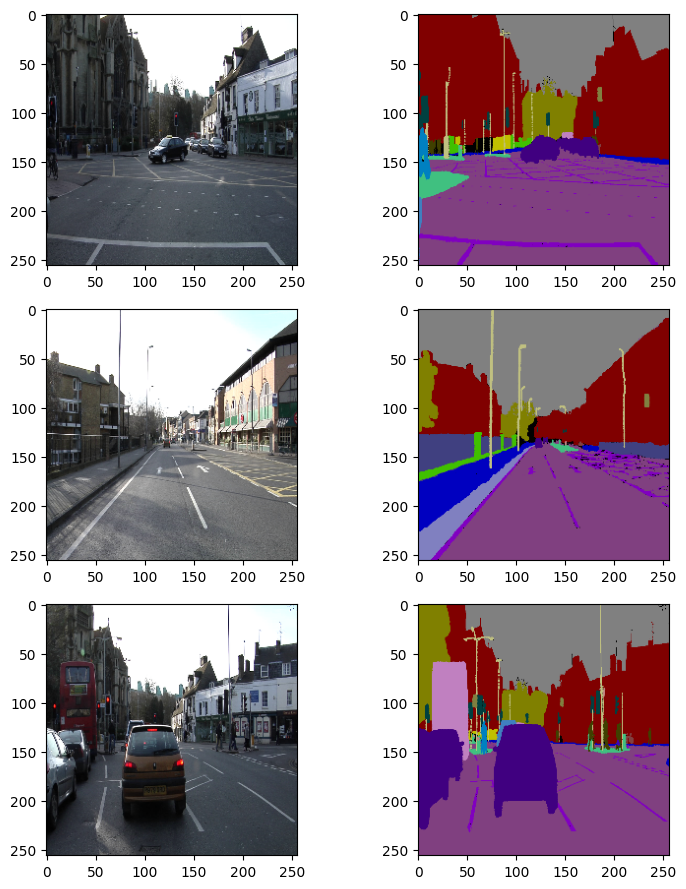

In [15]:
idx = np.random.randint(train_images.shape[0], size=3)
show_pairs(train_images[idx], train_masks[idx])

### Encoding Mask Labels

In [16]:
# keras.utils.to_categorical(train_masks)
# this does not work:
# Unable to allocate 52.2 GiB for an array with shape (72548352, 193) and data type float32

In [17]:
train_masks_encoded = adjust_mask(train_masks)

In [18]:
train_masks_encoded.shape

(369, 256, 256, 32)

In [19]:
train_masks_encoded[0,0,0,:].shape, train_masks_encoded[0,0,0,:]

((32,),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32))

In [20]:
train_masks_encoded[0,0,:,:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Preprocessing for modeling

In [21]:
train_masks_encoded = train_masks_encoded.astype("float32")

In [22]:
np.unique(train_masks_encoded)

array([0., 1.], dtype=float32)

Without touching out out OHE masks, we used normalization and not the dividision of every pixel by 255, obtaining pixel values between 0 and 1 in float32 format.
$$X_{normalized} = \frac{x-x_{min}}{x_{max}-x_{min}}$$

In [23]:
train_images = normalize(train_images, axis=1)

!!!!!!!Since we are dealing with a multiclass problem, there is a high chance that, as we can see from the images and masks, there is class imbalance in terms of weights meaning that there are some classes (like the road or the walls) that have much more in-sample observations with pixels associated to them, implying that other minority classes (such as people, animals, trees..) have less training examples. By pixels we mean 1s in the OHE mask tensor.!!!!!!!!!

Speaking about the training procedure, we could think that a Unet-like architecture should need many training examples. However Unet was conceived for biomedical images and complex structures working extremly well also with few examples (think about mithocondria or other cells to be analyzed: it's difficult to have a big, precise dataset of such pictures).

Now do the needed Preprocessing for validation and test set.

In [24]:
val_images = normalize(val_images, axis=1)
test_images = normalize(test_images, axis=1)

In [25]:
val_masks_encoded = adjust_mask(val_masks).astype("float32")
test_masks_encoded = adjust_mask(test_masks).astype("float32")

### UNET

In [26]:
from Models import Unet

In [27]:
train_images.shape

(369, 256, 256, 3)

In [28]:
IMG_HEIGHT = train_images.shape[1]
IMG_WIDTH  = train_images.shape[2]
IMG_CHANNELS = train_images.shape[3]

shapes = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [29]:
model = Unet(shapes, num_classes=32, dropout_rates=[0.1, 0.2, 0.3], batch_normalization=False)

In [30]:
# alternative
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(inputs)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(x)
    return x

def upsample_block(inputs, conv_prev, num_filters):
    up = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(inputs)
    concat = tf.keras.layers.concatenate([up, conv_prev])
    conv = conv_block(concat, num_filters)
    return conv


def alternative_unet(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, num_classes):
    inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)) 

    c1 = conv_block(inputs, 32)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    c2 = conv_block(p1, 64)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    c3 = conv_block(p2, 128)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    c4 = conv_block(p3, 256)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    c5 = conv_block(p4, 512)

    c6 = upsample_block(c5, c4, 256)
    c7 = upsample_block(c6, c3, 128)
    c8 = upsample_block(c7, c2, 64)
    c9 = upsample_block(c8, c1, 32)

    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

In [31]:
model2 = alternative_unet(shapes[0], shapes[1], shapes[2], 32)
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 256, 256, 32  0           ['conv2d_19[0][0]']              
                                )                                                           

In [32]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [33]:
history2 = model2.fit(train_images, train_masks_encoded, 
                    batch_size=16, 
                    verbose=1,
                    validation_data=(val_images, val_masks_encoded), 
                    epochs=1)

24/24 [==============================] - 258s 10s/step - loss: 2.9063 - accuracy: 0.1598 - val_loss: 2.2588 - val_accuracy: 0.2626


In [34]:
history = model.fit(train_images, train_masks_encoded, 
                    batch_size=16, 
                    verbose=1,
                    validation_data=(val_images, val_masks_encoded), 
                    epochs=1)

24/24 [==============================] - 264s 11s/step - loss: 3.2763 - accuracy: 0.2034 - val_loss: 2.9358 - val_accuracy: 0.2962


In [35]:
y_pred=model.predict(test_images)
y_pred_argmax=np.argmax(y_pred, axis=3)

8/8 [==============================] - 36s 5s/step


In [36]:
y_pred2=model2.predict(test_images)
y_pred_argmax2=np.argmax(y_pred2, axis=3)

8/8 [==============================] - 28s 3s/step


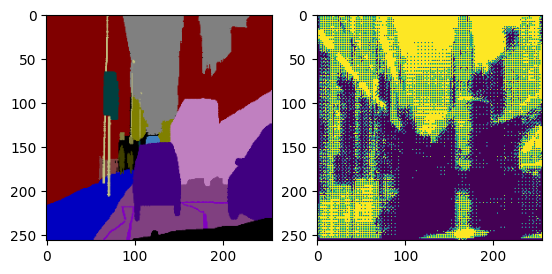

In [37]:
show_pairs(test_masks[0], y_pred_argmax[0,:,:])

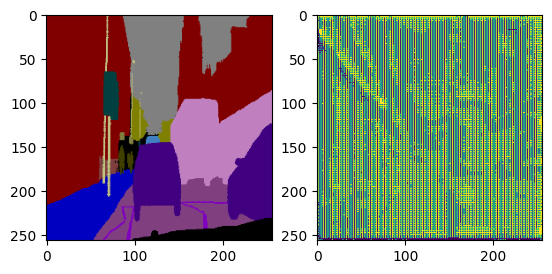

In [38]:
show_pairs(test_masks[0], y_pred_argmax2[0,:,:])

Having these results with only 1 epoch and a simple Unet, is data augmentation really needed?


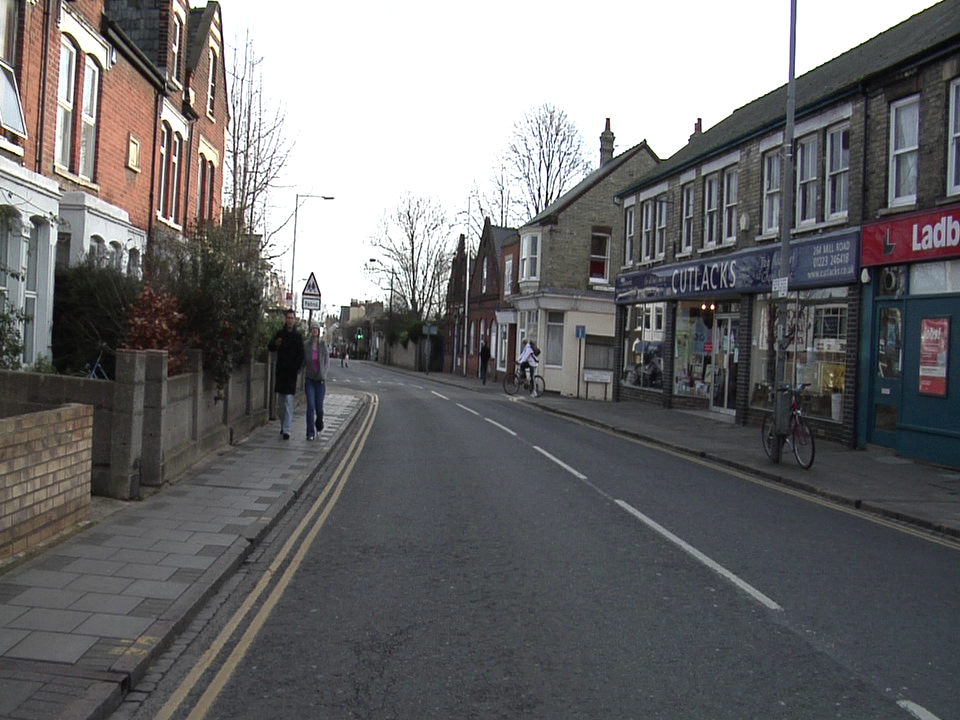
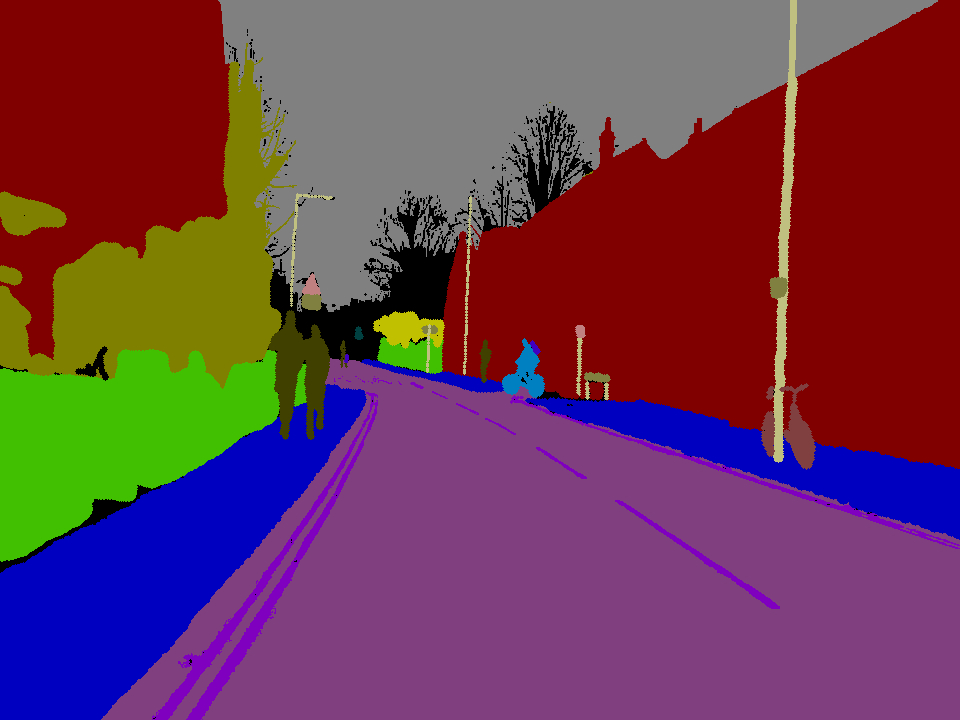

In [43]:
import leafmap

leafmap.image_comparison(
    "CamVid\\val\\Seq05VD_f04710.png",
    "CamVid\\val_labels\\Seq05VD_f04710_L.png",
    label1='Real Image',
    label2='Predicted Segmentation',
    starting_position=50,
    out_html='image_comparison.html',
)